# Metric results comp notebook
This notebook just calcs and compares metrics of different models preds on the test set

In [1]:
import torch
import os
import sys
import torchmetrics
import torch
import pandas as pd
import sumolib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import json

In [2]:
sys.path.append('..')
from util_folder.ml_utils.data_utils.data_loader_utils import IncidentDataModule
from util_folder.ml_utils.result_utils.plot_utils import plotNet
from util_folder.dotdict import DotDict
from util_folder.ml_utils.result_utils.metric_utils import (generate_masks, 
                                                            MetricObj, 
                                                            calc_aggregates, 
                                                            create_res_df, 
                                                            create_test_metrics)
from util_folder.ml_utils.result_utils.plot_utils import plot_classification_errors, plot_net_w_logits

In [3]:
def print_res_dict(res_dict, model):
    print(f'************  Results for: {model}  ************')
    for loss_part in res_dict.keys():
        print(f'##{loss_part}:##')
        metric_str = ''
        for metric in res_dict[loss_part].keys():
            metric_str +=  f'{metric} : {res_dict[loss_part][metric]:.02f} \t'
        print(metric_str)

In [4]:
base_dir = '/home/manity/Quick_adap/quick_adap_to_incidents/saved_models/baseline_comp/'
model_names = os.listdir(base_dir)
model_names
random_seeds = [41,42,43,44]

y_true = torch.load(f'{base_dir}/{model_names[0]}/y_true_{random_seeds[0]}.pt').cpu()

In [5]:
results_dict = {}
for name in model_names:
    results_dict[name] = {}
    for seed in random_seeds:
        results_dict[name][seed] = torch.load(f'{base_dir}/{name}/y_hat_{seed}.pt').cpu()
        assert (torch.load(f'{base_dir}/{name}/y_true_{seed}.pt').cpu() - y_true).sum() == 0

In [6]:
# Load net and dataset info
folder_path = f'../Simulation_scenarios/motorway/Results/incident_large'
incident_data_module = IncidentDataModule(folder_path = folder_path, batch_size = 100)
incident_data_module.setup()
test_dataloader = incident_data_module.test_dataloader()
test_dataset = test_dataloader.dataset

net_path = '../Simulation_scenarios/motorway/Simulations/Base/network.net.xml'
net = sumolib.net.readNet(net_path)

with open('../Simulation_scenarios/motorway/Results/incident_large/ind_to_edge.json') as f:
    ind_to_edge = json.load(f)

# Generate masks for subbsets
upstream_mask, multilane_mask, highway_mask, spreading_mask, affected_mask  = generate_masks(test_dataset)

*** DATA SUMMARY: ***
input_full.shape=torch.Size([10270, 147, 6, 10, 5])
target_full.shape=torch.Size([10270, 147, 4])
incident_info_full.shape=torch.Size([10270, 4])
network_info_full.shape=torch.Size([10270, 147, 13])



In [7]:
metric_obj = MetricObj(bce_pos_weight=25.5191)

full_test = {}
for model in model_names:
    full_test[model] = {}
    for seed in random_seeds:
        full_test[model][seed] = metric_obj.calc_metrics(y_hat=results_dict[model][seed], y_true=y_true)
full_test_aggregates = calc_aggregates(full_test, model_names, random_seeds)
full_test_df = create_res_df(full_test_aggregates)
del full_test

upstream_test_df, not_upstream_test_df = create_test_metrics(model_names, random_seeds, metric_obj, results_dict, y_true, upstream_mask)
multilane_test_df, not_multilane_test_df = create_test_metrics(model_names, random_seeds, metric_obj, results_dict, y_true, multilane_mask)
highway_test_df, not_highway_test_df = create_test_metrics(model_names, random_seeds, metric_obj, results_dict, y_true, highway_mask)
spreading_test_df, not_spreading_test_df = create_test_metrics(model_names, random_seeds, metric_obj, results_dict, y_true, spreading_mask)
affected_test_df, not_affected_test_df = create_test_metrics(model_names, random_seeds, metric_obj, results_dict, y_true, affected_mask)

In [8]:
n_hop_dfs = {}
for hop in range(11):
    n_hop_mask = (test_dataset.network_info[:,:,0] == -hop)
    temp_df, _ = create_test_metrics(model_names, random_seeds, metric_obj, results_dict, y_true, n_hop_mask)
    n_hop_dfs[hop] = temp_df

In [9]:
affected_n_hop_dfs = {}
for hop in range(11):
    affected_n_hop_mask = (test_dataset.network_info[:,:,0] == -hop) & affected_mask
    temp_df, _ = create_test_metrics(model_names, random_seeds, metric_obj, results_dict, y_true, affected_n_hop_mask)
    affected_n_hop_dfs[hop] = temp_df

In [10]:
df_arr = [full_test_df,
          upstream_test_df, not_upstream_test_df,
          multilane_test_df, not_multilane_test_df, 
          highway_test_df, not_highway_test_df, 
          spreading_test_df, not_spreading_test_df]


In [11]:

def print_res_df(res_dict, model):
    print(f'************  Results for: {model}  ************')
    for loss_part in res_dict.keys().get_level_values(0).unique():
        print(f'##{loss_part}:##')
        metric_str = ''
        for metric in res_dict[loss_part].keys():
            mean = res_dict[loss_part][metric]["mean"]
            std = res_dict[loss_part][metric]["std"]
            metric_str +=  f'{metric} : {mean:.03f} ({std:.03f}) \t'
        print(metric_str)

In [12]:
#for model in full_test_df.keys().get_level_values(0):
    #print_res_dict(full_test_df[model], model)
pd.set_option('display.max_rows', 500)
full_test_df.T

mean            std
mlp       end   mae    4.242228e+00       0.016285
                mape   1.657009e+06   13198.685547
                Mmape  9.178900e-01       0.000205
          start mae    1.329117e+00       0.006106
                mape   5.019790e+05    5482.369141
                Mmape  9.066223e-01       0.000816
          speed mae    1.324610e+00       0.007866
                mape   4.723104e+05    6714.217285
                Mmape  9.331599e-01       0.000395
          class acc    8.229454e-01       0.007883
                f1     1.286199e-01       0.002850
                prcsn  9.842056e-02       0.002256
                rcll   4.531704e-01       0.016579
lstm      end   mae    4.177135e+00       0.019729
                mape   1.604456e+06   18298.830078
                Mmape  9.181042e-01       0.001054
          start mae    1.300886e+00       0.011886
                mape   4.788309e+05   10780.817383
                Mmape  9.043672e-01       0.001911
          speed mae    1.288283e+00       0.014222
                mape   4.401981e+05   13113.212891
                Mmape  9.337952e-01       0.001398
          class acc    8.315416e-01       0.011116
                f1     1.340631e-01       0.001595
                prcsn  1.008369e-01       0.001964
                rcll   4.386158e-01       0.036497
attention end   mae    4.153527e+00       0.024979
                mape   1.583860e+06   23554.732422
                Mmape  9.195879e-01       0.001435
          start mae    1.299472e+00       0.007875
                mape   4.762321e+05    7555.871094
                Mmape  9.100444e-01       0.002161
          speed mae    1.275711e+00       0.012278
                mape   4.292588e+05   11349.479492
                Mmape  9.351647e-01       0.001061
          class acc    8.137523e-01       0.006700
                f1     1.385017e-01       0.001369
                prcsn  9.758887e-02       0.000592
                rcll   4.783660e-01       0.020301
tcn       end   mae    4.201388e+00       0.050000
                mape   1.621250e+06   43122.054688
                Mmape  9.192407e-01       0.000971
          start mae    1.317794e+00       0.019771
                mape   4.910674e+05   17048.945312
                Mmape  9.101785e-01       0.000905
          speed mae    1.304642e+00       0.023106
                mape   4.540011e+05   20267.689453
                Mmape  9.350199e-01       0.000799
          class acc    8.323721e-01       0.004511
                f1     1.282088e-01       0.005585
                prcsn  1.012357e-01       0.001296
                rcll   4.379122e-01       0.008857
dcrnn     end   mae    4.168804e+00       0.220662
                mape   1.609393e+06  205406.875000
                Mmape  9.163628e-01       0.009632
          start mae    1.299280e+00       0.071599
                mape   4.806613e+05   66333.992188
                Mmape  9.016482e-01       0.009476
          speed mae    1.253791e+00       0.073244
                mape   4.111196e+05   67557.296875
                Mmape  9.334273e-01       0.008873
          class acc    8.449309e-01       0.022289
                f1     1.518253e-01       0.009080
                prcsn  1.055989e-01       0.003494
                rcll   4.155527e-01       0.065817

# MLP

In [13]:
focus_model = 'mlp'

In [14]:
full_test_df[focus_model]

end                             start                           \
           mae          mape     Mmape       mae           mape     Mmape   
mean  4.242228  1.657009e+06  0.917890  1.329117  501979.000000  0.906622   
std   0.016285  1.319869e+04  0.000205  0.006106    5482.369141  0.000816   

         speed                              class                               
           mae           mape     Mmape       acc       f1     prcsn      rcll  
mean  1.324610  472310.406250  0.933160  0.822945  0.12862  0.098421  0.453170  
std   0.007866    6714.217285  0.000395  0.007883  0.00285  0.002256  0.016579

In [15]:
upstream_test_df[focus_model]

end                             start                           \
            mae          mape     Mmape       mae           mape     Mmape   
mean  17.412922  1.912913e+06  0.917890  5.561922  577091.500000  0.906622   
std    0.016254  1.881993e+04  0.000205  0.008972    9715.357422  0.000816   

         speed                              class                      \
           mae           mape     Mmape       acc        f1     prcsn   
mean  5.675619  504201.437500  0.933160  0.674974  0.483205  0.372608   
std   0.008427    6989.914551  0.000395  0.004950  0.004863  0.003554   

                
          rcll  
mean  0.453170  
std   0.016579

In [16]:
not_upstream_test_df[focus_model]

end                         start                          speed  \
           mae          mape Mmape       mae           mape Mmape       mae   
mean  1.885117  1.611211e+06   NaN  0.571588  488536.375000   NaN  0.545925   
std   0.019819  1.693931e+04   NaN  0.007270    6213.897461   NaN  0.009515   

                              class                  
               mape Mmape       acc   f1 prcsn rcll  
mean  466603.000000   NaN  0.849427  0.0   0.0  0.0  
std     8132.505371   NaN  0.008679  0.0   0.0  0.0

In [17]:
multilane_test_df[focus_model] 

end                             start                           \
           mae          mape     Mmape       mae           mape     Mmape   
mean  5.003551  1.587396e+06  0.917807  1.565091  481579.656250  0.906205   
std   0.017668  1.390639e+04  0.000330  0.005792    5184.828125  0.000679   

         speed                              class                               
           mae           mape     Mmape       acc        f1     prcsn     rcll  
mean  1.585583  452723.406250  0.933079  0.823429  0.171285  0.133899  0.46249  
std   0.008156    7028.181641  0.000272  0.007221  0.003869  0.003246  0.01577

In [18]:
not_multilane_test_df[focus_model]

end                             start                           \
           mae          mape     Mmape       mae           mape     Mmape   
mean  3.258285  1.746978e+06  0.918138  1.024142  528343.312500  0.907863   
std   0.015261  1.288477e+04  0.000492  0.006921    6076.124023  0.001442   

         speed                              class                      \
           mae           mape     Mmape       acc        f1     prcsn   
mean  0.987325  497624.812500  0.933401  0.822321  0.070482  0.052986   
std   0.007612    6423.905273  0.000807  0.008811  0.001811  0.001472   

                
          rcll  
mean  0.425437  
std   0.020704

In [19]:
highway_test_df[focus_model] 

end                             start                           \
           mae          mape     Mmape       mae           mape     Mmape   
mean  4.505801  1.658057e+06  0.916671  1.436804  501748.156250  0.908674   
std   0.015423  1.229434e+04  0.000351  0.005616    4939.178711  0.000466   

         speed                              class                      \
           mae           mape     Mmape       acc        f1     prcsn   
mean  1.445050  473627.125000  0.932539  0.819858  0.144833  0.108055   
std   0.007699    6644.174805  0.000235  0.007912  0.003343  0.002936   

                
          rcll  
mean  0.453751  
std   0.017264

In [20]:
not_highway_test_df[focus_model]

end                             start                           \
           mae          mape     Mmape       mae           mape     Mmape   
mean  3.806345  1.655276e+06  0.920655  1.151030  502360.718750  0.901969   
std   0.018146  1.509861e+04  0.000458  0.007001    6423.119141  0.001709   

         speed                              class                      \
           mae           mape     Mmape       acc        f1     prcsn   
mean  1.125432  470132.812500  0.934570  0.828051  0.100113  0.081809   
std   0.008241    6924.756348  0.000786  0.007940  0.002984  0.002848   

                
          rcll  
mean  0.451854  
std   0.020670

In [21]:
spreading_test_df[focus_model]

end                             start                          \
           mae          mape     Mmape       mae          mape     Mmape   
mean  5.934973  2.108776e+06  0.915579  1.861809  640201.62500  0.903763   
std   0.020869  1.669651e+04  0.000200  0.008222    7415.09082  0.000836   

         speed                              class                      \
           mae           mape     Mmape       acc        f1     prcsn   
mean  1.835743  598374.500000  0.930953  0.771849  0.150417  0.116090   
std   0.009663    8240.313477  0.000409  0.009897  0.003070  0.002648   

                
          rcll  
mean  0.469580  
std   0.017181

In [22]:
not_spreading_test_df[focus_model]

end                             start                           \
           mae          mape     Mmape       mae           mape     Mmape   
mean  1.112645  821771.50000  0.969195  0.344265  246430.140625  0.970108   
std   0.007823    6760.72168  0.001019  0.002466    2105.122559  0.001416   

         speed                              class                      \
           mae           mape     Mmape       acc        f1     prcsn   
mean  0.379617  239240.437500  0.982161  0.917414  0.009531  0.005215   
std   0.004640    3995.013428  0.000855  0.004183  0.000103  0.000324   

                
          rcll  
mean  0.088776  
std   0.005399

In [23]:
affected_test_df[focus_model]

end                          start                          speed  \
            mae      mape     Mmape        mae      mape     Mmape        mae   
mean  61.166332  0.917890  0.917890  19.697315  0.906622  0.906622  20.499352   
std    0.029146  0.000205  0.000205   0.012013  0.000816  0.000816   0.004037   

                             class                            
          mape     Mmape       acc        f1 prcsn      rcll  
mean  0.933160  0.933160  0.453170  0.830684   1.0  0.453170  
std   0.000395  0.000395  0.016579  0.007047   0.0  0.016579

In [24]:
not_affected_test_df[focus_model]

end                         start                          speed  \
           mae          mape Mmape       mae           mape Mmape       mae   
mean  2.014569  1.721854e+06   NaN  0.610299  521623.312500   NaN  0.574229   
std   0.016047  1.371536e+04   NaN  0.006665    5696.934082   NaN  0.008163   

                              class                  
               mape Mmape       acc   f1 prcsn rcll  
mean  490793.687500   NaN  0.837416  0.0   0.0  0.0  
std     6976.970703   NaN  0.008788  0.0   0.0  0.0

In [25]:
print(f'\tf1\tacc\tprcsn\trcll\tst mae\tend mae\tsp mae')
for hop in n_hop_dfs.keys():
    temp_df = n_hop_dfs[hop][focus_model]
    f1 = temp_df['class']['f1']
    acc = temp_df['class']['acc']
    prcsn = temp_df['class']['prcsn']
    rcll = temp_df['class']['rcll']
    start_mae = temp_df['start']['mae'] 
    end_mae = temp_df['end']['mae'] 
    speed_mae = temp_df['speed']['mae'] 
    print(f'{hop}:\t',
          f'{f1["mean"]:.02f}\t',
          f'{acc["mean"]:.02f}\t',
          f'{prcsn["mean"]:.02f}\t',
          f'{rcll["mean"]:.02f}\t',
          f'{start_mae["mean"]:.02f}\t',
          f'{end_mae["mean"]:.02f}\t',
          f'{speed_mae["mean"]:.02f}')


	f1	acc	prcsn	rcll	st mae	end mae	sp mae
0:	 0.56	 0.33	 0.88	 0.19	 8.55	 35.53	 17.32
1:	 0.66	 0.50	 0.89	 0.26	 7.27	 31.53	 13.25
2:	 0.70	 0.62	 0.79	 0.34	 7.06	 27.78	 10.74
3:	 0.70	 0.67	 0.70	 0.40	 7.11	 25.60	 9.13
4:	 0.68	 0.70	 0.65	 0.47	 7.04	 24.96	 8.20
5:	 0.66	 0.71	 0.58	 0.54	 6.65	 23.53	 7.28
6:	 0.63	 0.72	 0.54	 0.57	 6.74	 22.71	 6.88
7:	 0.62	 0.73	 0.53	 0.61	 6.99	 22.06	 6.56
8:	 0.58	 0.73	 0.49	 0.62	 6.94	 20.35	 6.05
9:	 0.56	 0.72	 0.45	 0.63	 7.41	 20.14	 5.73
10:	 0.52	 0.72	 0.41	 0.65	 7.51	 18.77	 5.17


In [26]:
print(f'\tf1\tacc\tprcsn\trcll\tst mae\tend mae\tsp mae')
for hop in n_hop_dfs.keys():
    temp_df = affected_n_hop_dfs[hop][focus_model]
    f1 = temp_df['class']['f1']
    acc = temp_df['class']['acc']
    prcsn = temp_df['class']['prcsn']
    rcll = temp_df['class']['rcll']
    start_mae = temp_df['start']['mae'] 
    end_mae = temp_df['end']['mae'] 
    speed_mae = temp_df['speed']['mae'] 
    print(f'{hop}:\t',
          f'{f1["mean"]:.02f}\t',
          f'{acc["mean"]:.02f}\t',
          f'{prcsn["mean"]:.02f}\t',
          f'{rcll["mean"]:.02f}\t',
          f'{start_mae["mean"]:.02f}\t',
          f'{end_mae["mean"]:.02f}\t',
          f'{speed_mae["mean"]:.02f}')

	f1	acc	prcsn	rcll	st mae	end mae	sp mae
0:	 0.58	 0.19	 1.00	 0.19	 10.54	 43.94	 21.50
1:	 0.70	 0.26	 1.00	 0.26	 11.10	 48.25	 20.33
2:	 0.78	 0.34	 1.00	 0.34	 13.44	 53.16	 20.65
3:	 0.82	 0.40	 1.00	 0.40	 15.69	 56.70	 20.40
4:	 0.86	 0.47	 1.00	 0.47	 17.28	 61.39	 20.36
5:	 0.90	 0.54	 1.00	 0.54	 18.34	 65.25	 20.41
6:	 0.91	 0.57	 1.00	 0.57	 20.05	 67.77	 20.77
7:	 0.92	 0.61	 1.00	 0.61	 22.21	 69.71	 20.92
8:	 0.93	 0.62	 1.00	 0.62	 24.68	 71.19	 21.35
9:	 0.94	 0.63	 1.00	 0.63	 27.91	 73.98	 21.12
10:	 0.94	 0.65	 1.00	 0.65	 31.33	 75.32	 20.71


Text(0.5, 1.0, 'mlp')

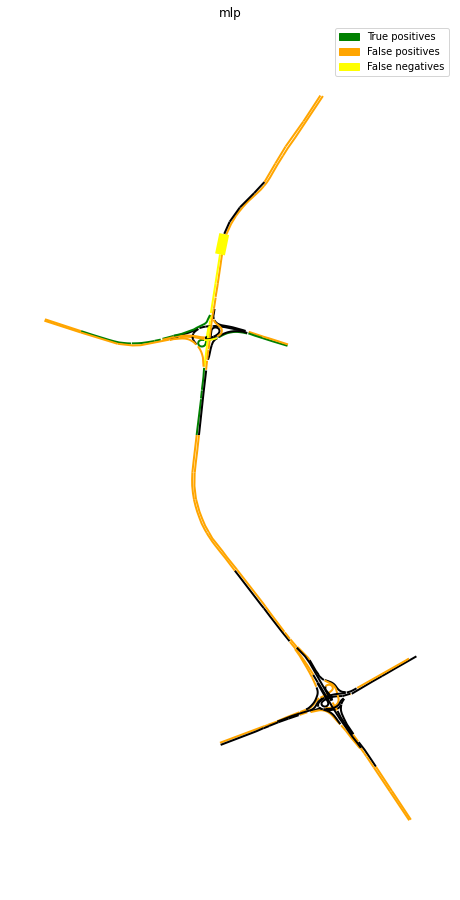

In [27]:
fig, ax = plt.subplots(figsize=(8,16))
plot_classification_errors(y_hat=results_dict[focus_model][41],
y_true=y_true,
seq_num=6,
incident_info=test_dataset.incident_info,
ind_to_edge=ind_to_edge,
net=net,
ax=ax)
ax.set_axis_off()
ax.set_title(focus_model)

Text(0.5, 1.0, 'mlp')

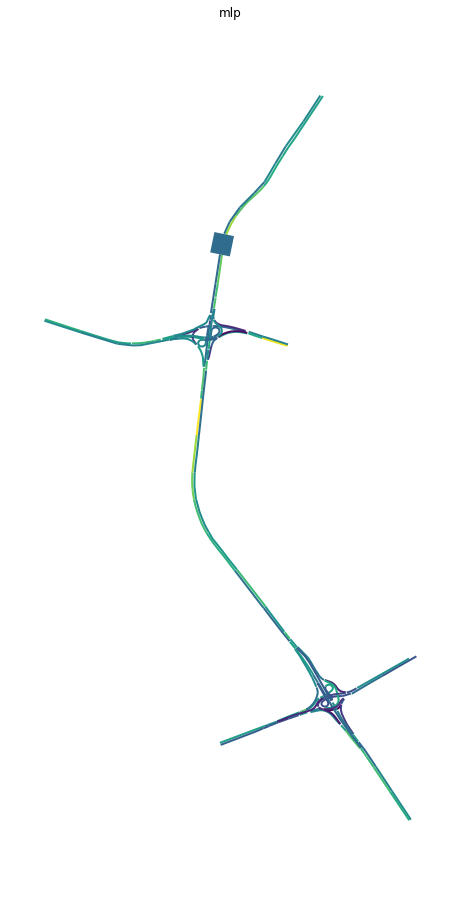

In [28]:
fig, ax = plt.subplots(figsize=(8,16))
plot_net_w_logits(y_hat=results_dict[focus_model][41],
                  seq_num=6,
                  incident_info=test_dataset.incident_info,
                  ind_to_edge=ind_to_edge,
                  net=net,
                  ax=ax)
ax.set_axis_off()
ax.set_title(focus_model)

Text(0.5, 1.0, 'False neg')

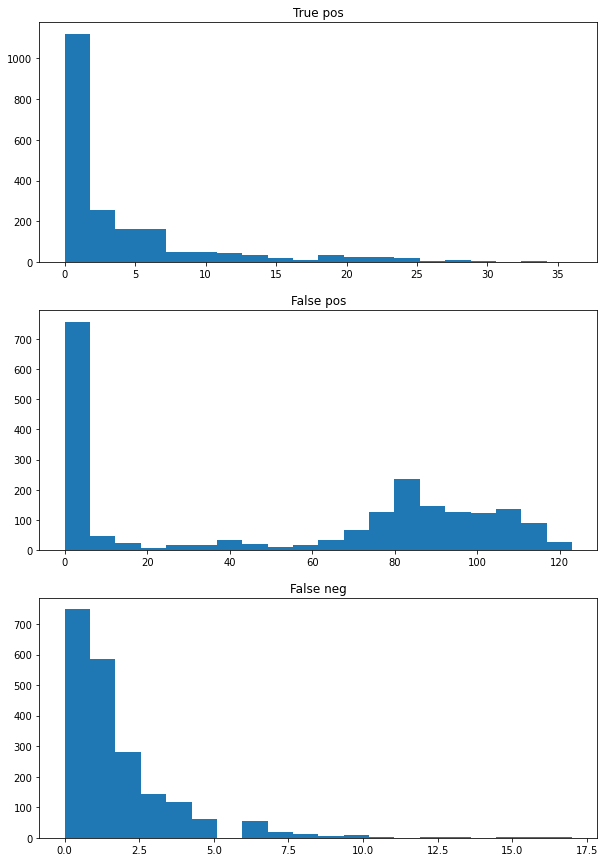

In [29]:
pred_classes = results_dict[focus_model][41][...,0] > 0
true_classes = y_true[...,0]
true_pos = pred_classes * true_classes
false_pos = pred_classes.int() - true_pos.int()
false_neg = true_classes.int() - true_pos.int()

fig, ax = plt.subplots(3, 1, figsize = (10,15))

ax[0].hist(true_pos.sum(1), bins=20)
ax[0].set_title('True pos')

ax[1].hist(false_pos.sum(1), bins=20)
ax[1].set_title('False pos')

ax[2].hist(false_neg.sum(1), bins=20)
ax[2].set_title('False neg')



# LSTM

In [30]:
focus_model = 'lstm'

In [31]:
full_test_df[focus_model]

end                             start                           \
           mae          mape     Mmape       mae           mape     Mmape   
mean  4.177135  1.604456e+06  0.918104  1.300886  478830.875000  0.904367   
std   0.019729  1.829883e+04  0.001054  0.011886   10780.817383  0.001911   

         speed                              class                      \
           mae           mape     Mmape       acc        f1     prcsn   
mean  1.288283  440198.062500  0.933795  0.831542  0.134063  0.100837   
std   0.014222   13113.212891  0.001398  0.011116  0.001595  0.001964   

                
          rcll  
mean  0.438616  
std   0.036497

In [32]:
upstream_test_df[focus_model]

end                             start                           \
            mae          mape     Mmape       mae           mape     Mmape   
mean  17.396397  1.919094e+06  0.918104  5.553961  576749.000000  0.904367   
std    0.021201  2.655056e+04  0.001054  0.007676   11625.770508  0.001911   

         speed                              class                      \
           mae           mape     Mmape       acc        f1     prcsn   
mean  5.658520  482578.062500  0.933795  0.680592  0.473246  0.376864   
std   0.016346   19331.226562  0.001398  0.008795  0.003090  0.005115   

                
          rcll  
mean  0.438616  
std   0.036497

In [33]:
not_upstream_test_df[focus_model]

end                         start                          speed  \
           mae          mape Mmape       mae           mape Mmape       mae   
mean  1.811332  1.548147e+06   NaN  0.539729  461306.812500   NaN  0.506158   
std   0.019776  1.690215e+04   NaN  0.012748   10895.587891   NaN  0.014981   

                              class                  
               mape Mmape       acc   f1 prcsn rcll  
mean  432613.437500   NaN  0.858557  0.0   0.0  0.0  
std    12804.417969   NaN  0.011827  0.0   0.0  0.0

In [34]:
multilane_test_df[focus_model] 

end                             start                           \
           mae          mape     Mmape       mae           mape     Mmape   
mean  4.928251  1.528588e+06  0.917816  1.533010  455815.812500  0.903381   
std   0.016432  1.602409e+04  0.001179  0.010813   10126.050781  0.002034   

         speed                              class                      \
           mae           mape     Mmape       acc        f1     prcsn   
mean  1.550006  421104.781250  0.933504  0.832200  0.178957  0.138370   
std   0.012579   12234.130859  0.001435  0.010019  0.001859  0.002935   

                
          rcll  
mean  0.450828  
std   0.039689

In [35]:
not_multilane_test_df[focus_model]

end                             start                           \
           mae          mape     Mmape       mae           mape     Mmape   
mean  3.206384  1.702510e+06  0.918961  1.000887  508575.750000  0.907301   
std   0.024370  2.153365e+04  0.001268  0.013393   11706.139648  0.002247   

         speed                              class                      \
           mae           mape     Mmape       acc        f1     prcsn   
mean  0.950029  464874.343750  0.934662  0.830691  0.072239  0.052971   
std   0.016362   14272.635742  0.001970  0.012537  0.001657  0.001091   

                
          rcll  
mean  0.402273  
std   0.027616

In [36]:
highway_test_df[focus_model] 

end                             start                           \
           mae          mape     Mmape       mae           mape     Mmape   
mean  4.432708  1.600537e+06  0.916339  1.406772  477490.187500  0.906142   
std   0.017392  1.710919e+04  0.001419  0.011320   10694.541016  0.002361   

         speed                              class                      \
           mae           mape     Mmape       acc        f1     prcsn   
mean  1.407032  440102.093750  0.933077  0.829111  0.151195  0.112820   
std   0.012934   12392.263672  0.001605  0.011360  0.002096  0.002563   

                
          rcll  
mean  0.447859  
std   0.039228

In [37]:
not_highway_test_df[focus_model]

end                             start                           \
           mae          mape     Mmape       mae           mape     Mmape   
mean  3.754482  1.610939e+06  0.922109  1.125779  481048.000000  0.900341   
std   0.023658  2.033819e+04  0.000754  0.012890   10969.089844  0.002365   

         speed                              class                      \
           mae           mape     Mmape       acc        f1     prcsn   
mean  1.091901  440356.750000  0.935424  0.835561  0.103772  0.080149   
std   0.016379   14327.571289  0.001138  0.010778  0.002563  0.001241   

                
          rcll  
mean  0.417649  
std   0.030404

In [38]:
spreading_test_df[focus_model]

end                             start                           \
           mae          mape     Mmape       mae           mape     Mmape   
mean  5.849392  2.040363e+06  0.915785  1.824143  609499.000000  0.901448   
std   0.025832  2.401780e+04  0.001048  0.015507   14155.722656  0.001890   

         speed                              class                               
           mae           mape     Mmape       acc        f1    prcsn      rcll  
mean  1.790632  558225.875000  0.931570  0.782625  0.156647  0.11885  0.454347  
std   0.018040   16807.259766  0.001425  0.013550  0.002136  0.00235  0.037425

In [39]:
not_spreading_test_df[focus_model]

end                              start                           \
           mae           mape     Mmape       mae           mape     Mmape   
mean  1.085431  798544.000000  0.969603  0.333478  237248.859375  0.969184   
std   0.012341   10535.938477  0.001486  0.005679    4907.473145  0.002509   

         speed                            class                                
           mae           mape   Mmape       acc        f1     prcsn      rcll  
mean  0.359530  221985.609375  0.9832  0.921979  0.009155  0.005527  0.089286  
std   0.008371    7196.811523  0.0009  0.006640  0.000352  0.000531  0.015928

In [40]:
affected_test_df[focus_model]

end                          start                          speed  \
            mae      mape     Mmape        mae      mape     Mmape        mae   
mean  61.070576  0.918104  0.918104  19.666840  0.904367  0.904367  20.532406   
std    0.067405  0.001054  0.001054   0.031139  0.001911  0.001911   0.033447   

                             class                            
          mape     Mmape       acc        f1 prcsn      rcll  
mean  0.933795  0.933795  0.438616  0.792291   1.0  0.438616  
std   0.001398  0.001398  0.036497  0.010409   0.0  0.036497

In [41]:
not_affected_test_df[focus_model]

end                         start                          speed  \
           mae          mape Mmape       mae           mape Mmape       mae   
mean  1.950677  1.667245e+06   NaN  0.582156  497569.312500   NaN  0.535187   
std   0.022248  1.901502e+04   NaN  0.013107   11202.713867   NaN  0.015943   

                              class                  
               mape Mmape       acc   f1 prcsn rcll  
mean  457424.625000   NaN  0.846918  0.0   0.0  0.0  
std    13626.411133   NaN  0.012928  0.0   0.0  0.0

In [42]:
print(f'\tf1\tacc\tprcsn\trcll\tst mae\tend mae\tsp mae')
for hop in n_hop_dfs.keys():
    temp_df = n_hop_dfs[hop][focus_model]
    f1 = temp_df['class']['f1']
    acc = temp_df['class']['acc']
    prcsn = temp_df['class']['prcsn']
    rcll = temp_df['class']['rcll']
    start_mae = temp_df['start']['mae'] 
    end_mae = temp_df['end']['mae'] 
    speed_mae = temp_df['speed']['mae'] 
    print(f'{hop}:\t',
          f'{f1["mean"]:.02f}\t',
          f'{acc["mean"]:.02f}\t',
          f'{prcsn["mean"]:.02f}\t',
          f'{rcll["mean"]:.02f}\t',
          f'{start_mae["mean"]:.02f}\t',
          f'{end_mae["mean"]:.02f}\t',
          f'{speed_mae["mean"]:.02f}')


	f1	acc	prcsn	rcll	st mae	end mae	sp mae
0:	 0.51	 0.32	 0.88	 0.18	 8.53	 35.55	 17.34
1:	 0.61	 0.49	 0.89	 0.25	 7.28	 31.59	 13.29
2:	 0.65	 0.61	 0.80	 0.32	 7.06	 27.79	 10.77
3:	 0.66	 0.66	 0.71	 0.38	 7.09	 25.52	 9.13
4:	 0.66	 0.69	 0.65	 0.46	 7.04	 24.92	 8.21
5:	 0.64	 0.71	 0.58	 0.51	 6.64	 23.51	 7.29
6:	 0.62	 0.72	 0.55	 0.56	 6.72	 22.70	 6.88
7:	 0.61	 0.73	 0.52	 0.58	 6.98	 22.04	 6.56
8:	 0.58	 0.73	 0.48	 0.60	 6.95	 20.36	 6.04
9:	 0.56	 0.72	 0.45	 0.60	 7.41	 20.13	 5.72
10:	 0.54	 0.72	 0.41	 0.65	 7.49	 18.69	 5.13


In [43]:
print(f'\tf1\tacc\tprcsn\trcll\tst mae\tend mae\tsp mae')
for hop in n_hop_dfs.keys():
    temp_df = affected_n_hop_dfs[hop][focus_model]
    f1 = temp_df['class']['f1']
    acc = temp_df['class']['acc']
    prcsn = temp_df['class']['prcsn']
    rcll = temp_df['class']['rcll']
    start_mae = temp_df['start']['mae'] 
    end_mae = temp_df['end']['mae'] 
    speed_mae = temp_df['speed']['mae'] 
    print(f'{hop}:\t',
          f'{f1["mean"]:.02f}\t',
          f'{acc["mean"]:.02f}\t',
          f'{prcsn["mean"]:.02f}\t',
          f'{rcll["mean"]:.02f}\t',
          f'{start_mae["mean"]:.02f}\t',
          f'{end_mae["mean"]:.02f}\t',
          f'{speed_mae["mean"]:.02f}')

	f1	acc	prcsn	rcll	st mae	end mae	sp mae
0:	 0.53	 0.18	 1.00	 0.18	 10.54	 44.01	 21.54
1:	 0.64	 0.25	 1.00	 0.25	 11.10	 48.33	 20.38
2:	 0.71	 0.32	 1.00	 0.32	 13.48	 53.23	 20.74
3:	 0.77	 0.38	 1.00	 0.38	 15.66	 56.60	 20.45
4:	 0.82	 0.46	 1.00	 0.46	 17.25	 61.31	 20.41
5:	 0.85	 0.51	 1.00	 0.51	 18.33	 65.25	 20.48
6:	 0.87	 0.56	 1.00	 0.56	 20.03	 67.76	 20.85
7:	 0.89	 0.58	 1.00	 0.58	 22.16	 69.60	 20.98
8:	 0.90	 0.60	 1.00	 0.60	 24.65	 71.10	 21.42
9:	 0.91	 0.60	 1.00	 0.60	 27.86	 73.82	 21.16
10:	 0.93	 0.65	 1.00	 0.65	 31.19	 74.85	 20.67


Text(0.5, 1.0, 'lstm')

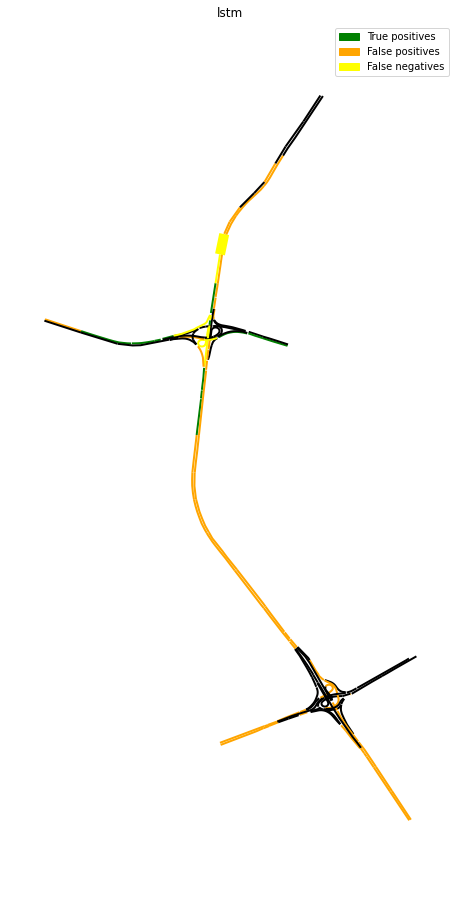

In [44]:
fig, ax = plt.subplots(figsize=(8,16))
plot_classification_errors(y_hat=results_dict[focus_model][41],
y_true=y_true,
seq_num=6,
incident_info=test_dataset.incident_info,
ind_to_edge=ind_to_edge,
net=net,
ax=ax)
ax.set_axis_off()
ax.set_title(focus_model)

Text(0.5, 1.0, 'lstm')

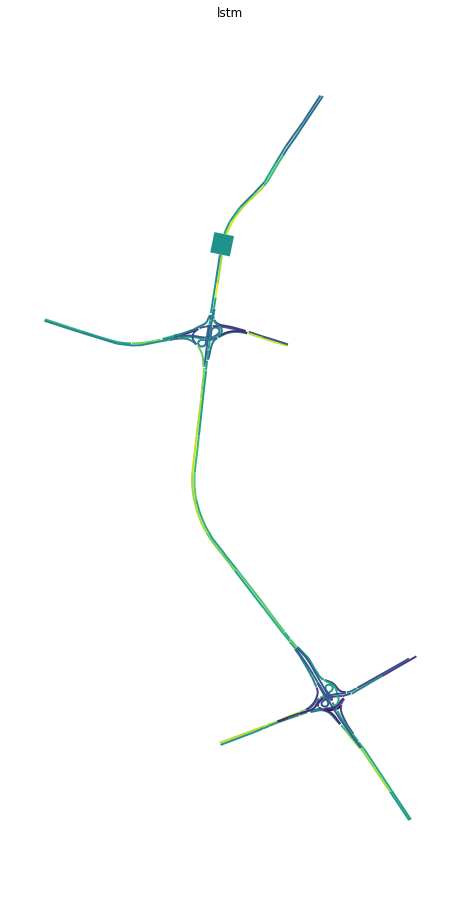

In [45]:
fig, ax = plt.subplots(figsize=(8,16))
plot_net_w_logits(y_hat=results_dict[focus_model][41],
                  seq_num=6,
                  incident_info=test_dataset.incident_info,
                  ind_to_edge=ind_to_edge,
                  net=net,
                  ax=ax)
ax.set_axis_off()
ax.set_title(focus_model)

Text(0.5, 1.0, 'False neg')

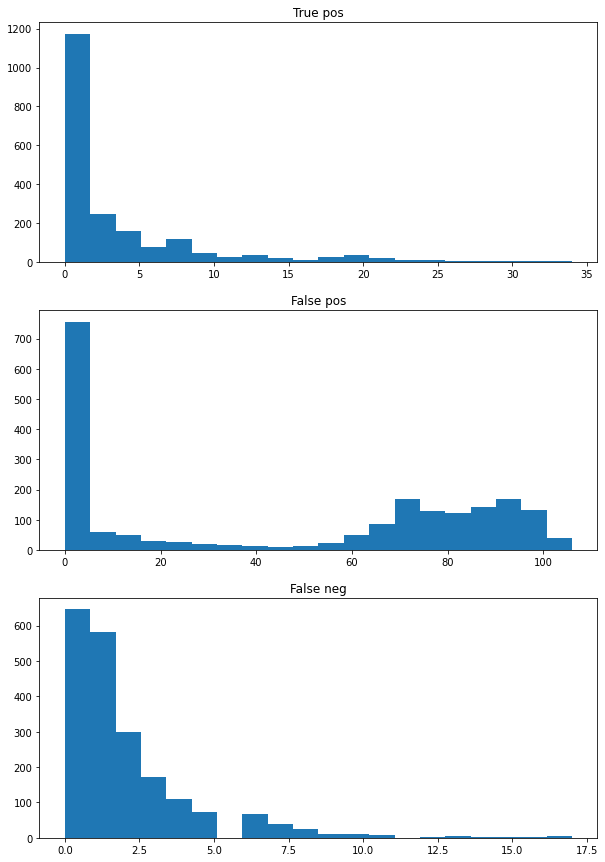

In [46]:
pred_classes = results_dict[focus_model][41][...,0] > 0
true_classes = y_true[...,0]
true_pos = pred_classes * true_classes
false_pos = pred_classes.int() - true_pos.int()
false_neg = true_classes.int() - true_pos.int()

fig, ax = plt.subplots(3, 1, figsize = (10,15))

ax[0].hist(true_pos.sum(1), bins=20)
ax[0].set_title('True pos')

ax[1].hist(false_pos.sum(1), bins=20)
ax[1].set_title('False pos')

ax[2].hist(false_neg.sum(1), bins=20)
ax[2].set_title('False neg')



# Attention

In [49]:
focus_model = 'attention'

In [50]:
full_test_df[focus_model]

end                             start                           \
           mae          mape     Mmape       mae           mape     Mmape   
mean  4.153527  1.583860e+06  0.919588  1.299472  476232.062500  0.910044   
std   0.024979  2.355473e+04  0.001435  0.007875    7555.871094  0.002161   

         speed                              class                      \
           mae           mape     Mmape       acc        f1     prcsn   
mean  1.275711  429258.750000  0.935165  0.813752  0.138502  0.097589   
std   0.012278   11349.479492  0.001061  0.006700  0.001369  0.000592   

                
          rcll  
mean  0.478366  
std   0.020301

In [51]:
upstream_test_df[focus_model]

end                             start                           \
            mae          mape     Mmape       mae           mape     Mmape   
mean  17.407093  1.925473e+06  0.919588  5.555871  569221.750000  0.910044   
std    0.042595  5.098570e+04  0.001435  0.011071   15255.058594  0.002161   

         speed                              class                      \
           mae           mape     Mmape       acc        f1     prcsn   
mean  5.668339  489691.062500  0.935165  0.672825  0.467873  0.375205   
std   0.017051   20280.339844  0.001061  0.006810  0.003762  0.004478   

                
          rcll  
mean  0.478366  
std   0.020301

In [52]:
not_upstream_test_df[focus_model]

end                        start                          speed  \
           mae          mape Mmape      mae           mape Mmape       mae   
mean  1.781585  1.522722e+06   NaN  0.53772  459590.031250   NaN  0.489579   
std   0.022745  1.944050e+04   NaN  0.00766    6546.623535   NaN  0.011494   

                              class                  
               mape Mmape       acc   f1 prcsn rcll  
mean  418443.375000   NaN  0.838974  0.0   0.0  0.0  
std     9824.335938   NaN  0.006767  0.0   0.0  0.0

In [53]:
multilane_test_df[focus_model] 

end                             start                           \
           mae          mape     Mmape       mae           mape     Mmape   
mean  4.907387  1.509258e+06  0.919248  1.533827  454529.312500  0.908933   
std   0.021934  2.178591e+04  0.001551  0.006555    6724.353027  0.002316   

         speed                              class                      \
           mae           mape     Mmape       acc        f1     prcsn   
mean  1.537027  409626.062500  0.934868  0.815470  0.183941  0.133567   
std   0.010070    9847.146484  0.001100  0.005839  0.002150  0.001065   

                
          rcll  
mean  0.490454  
std   0.023221

In [54]:
not_multilane_test_df[focus_model]

end                             start                           \
           mae          mape     Mmape       mae           mape     Mmape   
mean  3.179231  1.680276e+06  0.920600  0.996590  504280.875000  0.913351   
std   0.029906  2.663074e+04  0.001155  0.009675    8745.745117  0.001748   

         speed                              class                               
           mae           mape     Mmape       acc        f1    prcsn      rcll  
mean  0.937984  454632.250000  0.936049  0.811532  0.075927  0.05169  0.442395  
std   0.015163   13345.931641  0.001108  0.007908  0.000437  0.00103  0.011664

In [55]:
highway_test_df[focus_model] 

end                             start                           \
           mae          mape     Mmape       mae           mape     Mmape   
mean  4.410099  1.579775e+06  0.917939  1.404595  473978.093750  0.911480   
std   0.025242  2.423283e+04  0.001602  0.008065    7858.181152  0.002354   

         speed                              class                      \
           mae           mape     Mmape       acc        f1     prcsn   
mean  1.395287  429534.687500  0.934690  0.811555  0.154217  0.108172   
std   0.011947   11170.191406  0.001118  0.006614  0.001945  0.000921   

                
          rcll  
mean  0.482229  
std   0.024375

In [56]:
not_highway_test_df[focus_model]

end                             start                           \
           mae          mape     Mmape       mae           mape     Mmape   
mean  3.729223  1.590615e+06  0.923328  1.125627  479959.531250  0.906787   
std   0.024637  2.251349e+04  0.001085  0.007695    7167.003418  0.001863   

         speed                              class                      \
           mae           mape     Mmape       acc        f1     prcsn   
mean  1.077964  428802.437500  0.936243  0.817386  0.110865  0.079484   
std   0.012847   11650.097656  0.001065  0.006842  0.001625  0.001574   

                
          rcll  
mean  0.469603  
std   0.011989

In [57]:
spreading_test_df[focus_model]

end                             start                           \
           mae          mape     Mmape       mae           mape     Mmape   
mean  5.817080  2.012162e+06  0.917310  1.822396  605922.875000  0.907260   
std   0.028919  2.795700e+04  0.001446  0.009438    9280.849609  0.002206   

         speed                              class                      \
           mae           mape     Mmape       acc        f1     prcsn   
mean  1.773498  543288.687500  0.932993  0.760281  0.161592  0.115064   
std   0.014450   13617.129883  0.001073  0.008030  0.001525  0.000730   

                
          rcll  
mean  0.495726  
std   0.020873

In [58]:
not_spreading_test_df[focus_model]

end                              start                           \
           mae           mape     Mmape       mae           mape     Mmape   
mean  1.077915  792005.375000  0.970176  0.332681  236456.796875  0.971879   
std   0.018379   15843.652344  0.001769  0.005348    4597.059082  0.001457   

         speed                              class                      \
           mae           mape     Mmape       acc        f1     prcsn   
mean  0.355393  218437.734375  0.983400  0.912612  0.009566  0.005127   
std   0.008410    7243.899902  0.000956  0.004257  0.000347  0.000326   

                
          rcll  
mean  0.092857  
std   0.009499

In [59]:
affected_test_df[focus_model]

end                          start                          speed  \
            mae      mape     Mmape        mae      mape     Mmape        mae   
mean  61.083607  0.919588  0.919588  19.710037  0.910044  0.910044  20.538441   
std    0.070883  0.001435  0.001435   0.027587  0.002161  0.002161   0.028550   

                             class                            
          mape     Mmape       acc        f1 prcsn      rcll  
mean  0.935165  0.935165  0.478366  0.786088   1.0  0.478366  
std   0.001061  0.001061  0.020301  0.007480   0.0  0.020301

In [60]:
not_affected_test_df[focus_model]

end                         start                          speed  \
           mae          mape Mmape       mae           mape Mmape       mae   
mean  1.925635  1.645842e+06   NaN  0.578996  494868.781250   NaN  0.521887   
std   0.028638  2.447657e+04   NaN  0.009186    7851.617188   NaN  0.013799   

                              class                  
               mape Mmape       acc   f1 prcsn rcll  
mean  446057.218750   NaN  0.826877  0.0   0.0  0.0  
std    11793.609375   NaN  0.007747  0.0   0.0  0.0

In [61]:
print(f'\tf1\tacc\tprcsn\trcll\tst mae\tend mae\tsp mae')
for hop in n_hop_dfs.keys():
    temp_df = n_hop_dfs[hop][focus_model]
    f1 = temp_df['class']['f1']
    acc = temp_df['class']['acc']
    prcsn = temp_df['class']['prcsn']
    rcll = temp_df['class']['rcll']
    start_mae = temp_df['start']['mae'] 
    end_mae = temp_df['end']['mae'] 
    speed_mae = temp_df['speed']['mae'] 
    print(f'{hop}:\t',
          f'{f1["mean"]:.02f}\t',
          f'{acc["mean"]:.02f}\t',
          f'{prcsn["mean"]:.02f}\t',
          f'{rcll["mean"]:.02f}\t',
          f'{start_mae["mean"]:.02f}\t',
          f'{end_mae["mean"]:.02f}\t',
          f'{speed_mae["mean"]:.02f}')


	f1	acc	prcsn	rcll	st mae	end mae	sp mae
0:	 0.49	 0.33	 0.88	 0.20	 8.57	 35.60	 17.36
1:	 0.59	 0.51	 0.89	 0.28	 7.32	 31.61	 13.29
2:	 0.64	 0.62	 0.80	 0.35	 7.09	 27.84	 10.77
3:	 0.65	 0.67	 0.71	 0.42	 7.12	 25.62	 9.15
4:	 0.66	 0.71	 0.66	 0.51	 7.05	 24.93	 8.21
5:	 0.64	 0.71	 0.58	 0.56	 6.67	 23.53	 7.28
6:	 0.62	 0.72	 0.55	 0.59	 6.76	 22.73	 6.88
7:	 0.62	 0.73	 0.52	 0.62	 7.00	 22.04	 6.55
8:	 0.58	 0.73	 0.49	 0.66	 6.94	 20.29	 6.03
9:	 0.56	 0.72	 0.46	 0.67	 7.40	 20.08	 5.71
10:	 0.53	 0.72	 0.42	 0.70	 7.50	 18.69	 5.14


In [62]:
print(f'\tf1\tacc\tprcsn\trcll\tst mae\tend mae\tsp mae')
for hop in n_hop_dfs.keys():
    temp_df = affected_n_hop_dfs[hop][focus_model]
    f1 = temp_df['class']['f1']
    acc = temp_df['class']['acc']
    prcsn = temp_df['class']['prcsn']
    rcll = temp_df['class']['rcll']
    start_mae = temp_df['start']['mae'] 
    end_mae = temp_df['end']['mae'] 
    speed_mae = temp_df['speed']['mae'] 
    print(f'{hop}:\t',
          f'{f1["mean"]:.02f}\t',
          f'{acc["mean"]:.02f}\t',
          f'{prcsn["mean"]:.02f}\t',
          f'{rcll["mean"]:.02f}\t',
          f'{start_mae["mean"]:.02f}\t',
          f'{end_mae["mean"]:.02f}\t',
          f'{speed_mae["mean"]:.02f}')

	f1	acc	prcsn	rcll	st mae	end mae	sp mae
0:	 0.51	 0.20	 1.00	 0.20	 10.59	 44.06	 21.56
1:	 0.62	 0.28	 1.00	 0.28	 11.16	 48.37	 20.40
2:	 0.71	 0.35	 1.00	 0.35	 13.52	 53.30	 20.74
3:	 0.77	 0.42	 1.00	 0.42	 15.74	 56.79	 20.47
4:	 0.81	 0.51	 1.00	 0.51	 17.32	 61.35	 20.41
5:	 0.85	 0.56	 1.00	 0.56	 18.42	 65.29	 20.46
6:	 0.87	 0.59	 1.00	 0.59	 20.12	 67.79	 20.82
7:	 0.89	 0.62	 1.00	 0.62	 22.24	 69.64	 20.94
8:	 0.90	 0.66	 1.00	 0.66	 24.69	 70.99	 21.36
9:	 0.91	 0.67	 1.00	 0.67	 27.92	 73.72	 21.12
10:	 0.92	 0.70	 1.00	 0.70	 31.28	 74.86	 20.67


Text(0.5, 1.0, 'attention')

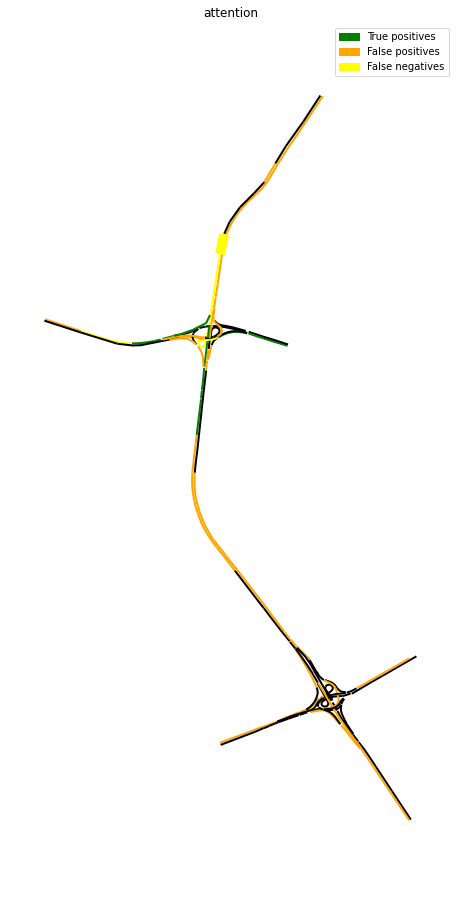

In [63]:
fig, ax = plt.subplots(figsize=(8,16))
plot_classification_errors(y_hat=results_dict[focus_model][41],
y_true=y_true,
seq_num=6,
incident_info=test_dataset.incident_info,
ind_to_edge=ind_to_edge,
net=net,
ax=ax)
ax.set_axis_off()
ax.set_title(focus_model)

Text(0.5, 1.0, 'attention')

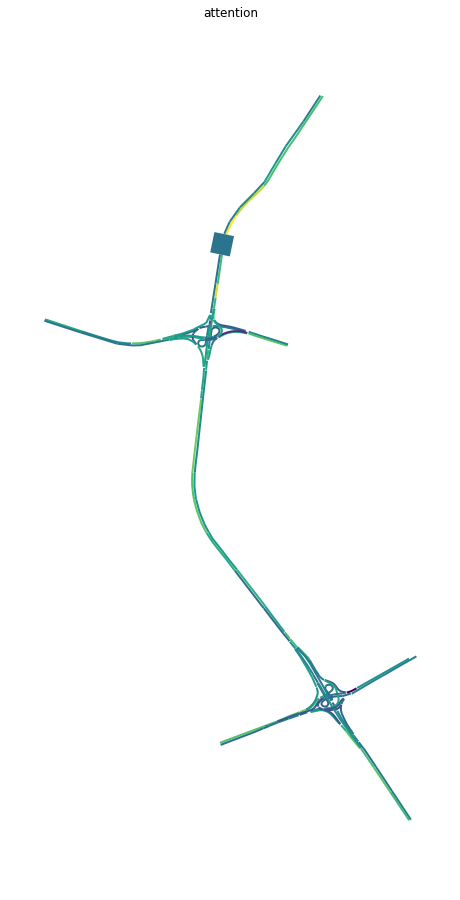

In [64]:
fig, ax = plt.subplots(figsize=(8,16))
plot_net_w_logits(y_hat=results_dict[focus_model][41],
                  seq_num=6,
                  incident_info=test_dataset.incident_info,
                  ind_to_edge=ind_to_edge,
                  net=net,
                  ax=ax)
ax.set_axis_off()
ax.set_title(focus_model)

Text(0.5, 1.0, 'False neg')

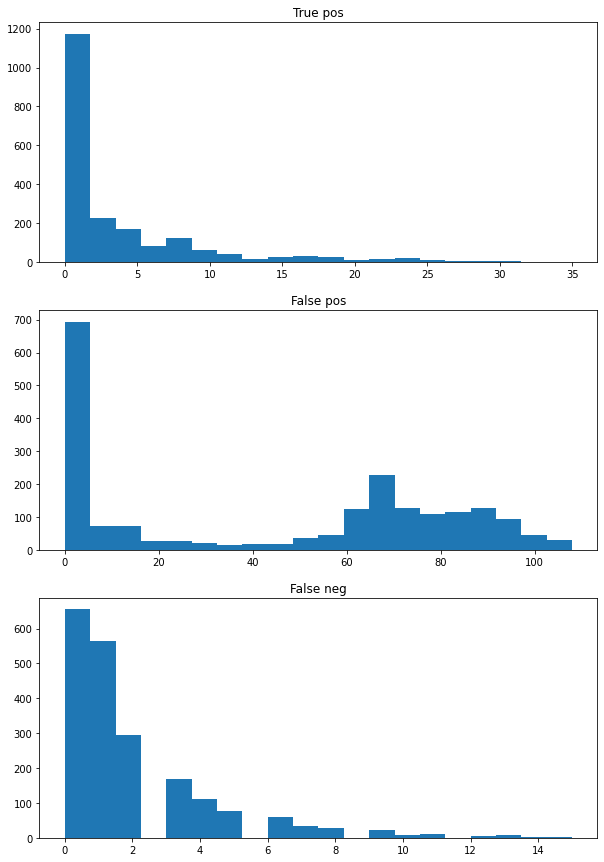

In [65]:
pred_classes = results_dict[focus_model][41][...,0] > 0
true_classes = y_true[...,0]
true_pos = pred_classes * true_classes
false_pos = pred_classes.int() - true_pos.int()
false_neg = true_classes.int() - true_pos.int()

fig, ax = plt.subplots(3, 1, figsize = (10,15))

ax[0].hist(true_pos.sum(1), bins=20)
ax[0].set_title('True pos')

ax[1].hist(false_pos.sum(1), bins=20)
ax[1].set_title('False pos')

ax[2].hist(false_neg.sum(1), bins=20)
ax[2].set_title('False neg')



# TCN

In [66]:
focus_model = 'tcn'

In [67]:
full_test_df[focus_model]

end                             start                           \
           mae          mape     Mmape       mae           mape     Mmape   
mean  4.201388  1.621250e+06  0.919241  1.317794  491067.437500  0.910179   
std   0.050000  4.312205e+04  0.000971  0.019771   17048.945312  0.000905   

         speed                              class                      \
           mae           mape     Mmape       acc        f1     prcsn   
mean  1.304642  454001.093750  0.935020  0.832372  0.128209  0.101236   
std   0.023106   20267.689453  0.000799  0.004511  0.005585  0.001296   

                
          rcll  
mean  0.437912  
std   0.008857

In [68]:
upstream_test_df[focus_model]

end                             start                           \
            mae          mape     Mmape       mae           mape     Mmape   
mean  17.403042  1.898846e+06  0.919241  5.556512  564343.250000  0.910179   
std    0.026648  2.711346e+04  0.000971  0.013271   12458.053711  0.000905   

         speed                              class                      \
           mae           mape     Mmape       acc        f1     prcsn   
mean  5.663515  485669.531250  0.935020  0.682283  0.481085  0.378717   
std   0.011055   12456.452148  0.000799  0.003804  0.005654  0.003993   

                
          rcll  
mean  0.437912  
std   0.008857

In [69]:
not_upstream_test_df[focus_model]

end                         start                         speed  \
           mae          mape Mmape       mae           mape Mmape      mae   
mean  1.838736  1.571569e+06   NaN  0.559206  477953.531250   NaN  0.52455   
std   0.054964  4.697798e+04   NaN  0.020941   17898.244141   NaN  0.02555   

                              class                  
               mape Mmape       acc   f1 prcsn rcll  
mean  448333.562500   NaN  0.859233  0.0   0.0  0.0  
std    21837.810547   NaN  0.005005  0.0   0.0  0.0

In [70]:
multilane_test_df[focus_model] 

end                             start                           \
           mae          mape     Mmape       mae           mape     Mmape   
mean  4.957510  1.547308e+06  0.919022  1.553273  469968.312500  0.909399   
std   0.050699  4.373703e+04  0.000903  0.020049   17260.371094  0.000730   

         speed                              class                      \
           mae           mape     Mmape       acc        f1     prcsn   
mean  1.565318  433738.625000  0.934814  0.833420  0.170746  0.139238   
std   0.022528   19974.984375  0.000802  0.003947  0.007553  0.001493   

                
          rcll  
mean  0.449830  
std   0.009177

In [71]:
not_multilane_test_df[focus_model]

end                             start                           \
           mae          mape     Mmape       mae           mape     Mmape   
mean  3.224167  1.716812e+06  0.919891  1.013458  518336.125000  0.912499   
std   0.049221  4.237662e+04  0.001515  0.019439   16789.882812  0.001501   

         speed                              class                      \
           mae           mape     Mmape       acc        f1     prcsn   
mean  0.967741  480188.531250  0.935633  0.831018  0.070238  0.053065   
std   0.023874   20658.539062  0.001157  0.005252  0.002858  0.001042   

                
          rcll  
mean  0.402448  
std   0.008832

In [72]:
highway_test_df[focus_model] 

end                            start                        \
           mae          mape    Mmape       mae        mape     Mmape   
mean  4.458556  1.617495e+06  0.91763  1.423426  489242.625  0.911633   
std   0.049009  4.232559e+04  0.00101  0.019580   16932.125  0.000895   

         speed                              class                      \
           mae           mape     Mmape       acc        f1     prcsn   
mean  1.423512  453827.687500  0.934324  0.830365  0.143787  0.113475   
std   0.022559   19837.669922  0.000787  0.004812  0.006012  0.001801   

                
          rcll  
mean  0.446687  
std   0.009523

In [73]:
not_highway_test_df[focus_model]

end                             start                           \
           mae          mape     Mmape       mae           mape     Mmape   
mean  3.776097  1.627459e+06  0.922894  1.143105  494085.187500  0.906879   
std   0.052104  4.481179e+04  0.000916  0.020279   17408.554688  0.001477   

         speed                              class                      \
           mae           mape     Mmape       acc        f1     prcsn   
mean  1.108060  454287.875000  0.936598  0.835691  0.100904  0.080258   
std   0.024096   21047.599609  0.000829  0.004143  0.004714  0.001937   

                
          rcll  
mean  0.418008  
std   0.011288

In [74]:
spreading_test_df[focus_model]

end                             start                           \
           mae          mape     Mmape       mae           mape     Mmape   
mean  5.883685  2.063659e+06  0.916960  1.847426  626031.000000  0.907432   
std   0.062753  5.410102e+04  0.000954  0.024794   21375.361328  0.000941   

         speed                              class                      \
           mae           mape     Mmape       acc        f1     prcsn   
mean  1.811714  575975.562500  0.932845  0.783272  0.149683  0.119096   
std   0.028082   24759.314453  0.000790  0.005234  0.006084  0.001257   

                
          rcll  
mean  0.453704  
std   0.009341

In [75]:
not_spreading_test_df[focus_model]

end                              start                           \
           mae           mape     Mmape       mae           mape     Mmape   
mean  1.091124  803314.562500  0.969878  0.338598  241543.906250  0.971163   
std   0.026615   22981.990234  0.002162  0.010483    9050.689453  0.002652   

         speed                              class                      \
           mae           mape     Mmape       acc        f1     prcsn   
mean  0.367157  228492.125000  0.983313  0.923149  0.009225  0.005536   
std   0.014016   12063.498047  0.001673  0.003215  0.000718  0.000458   

                
          rcll  
mean  0.087245  
std   0.004207

In [76]:
affected_test_df[focus_model]

end                          start                          speed  \
            mae      mape     Mmape        mae      mape     Mmape        mae   
mean  61.192856  0.919241  0.919241  19.735628  0.910179  0.910179  20.537960   
std    0.022313  0.000971  0.000971   0.007743  0.000905  0.000905   0.016158   

                             class                            
          mape     Mmape       acc        f1 prcsn      rcll  
mean  0.935020  0.935020  0.437912  0.816358   1.0  0.437912  
std   0.000799  0.000799  0.008857  0.022980   0.0  0.008857

In [77]:
not_affected_test_df[focus_model]

end                         start                          speed  \
           mae          mape Mmape       mae           mape Mmape       mae   
mean  1.971094  1.684696e+06   NaN  0.597033  510284.718750   NaN  0.551968   
std   0.052427  4.480949e+04   NaN  0.020728   17716.117188   NaN  0.024641   

                              class                  
               mape Mmape       acc   f1 prcsn rcll  
mean  471767.843750   NaN  0.847809  0.0   0.0  0.0  
std    21060.845703   NaN  0.005025  0.0   0.0  0.0

In [78]:
print(f'\tf1\tacc\tprcsn\trcll\tst mae\tend mae\tsp mae')
for hop in n_hop_dfs.keys():
    temp_df = n_hop_dfs[hop][focus_model]
    f1 = temp_df['class']['f1']
    acc = temp_df['class']['acc']
    prcsn = temp_df['class']['prcsn']
    rcll = temp_df['class']['rcll']
    start_mae = temp_df['start']['mae'] 
    end_mae = temp_df['end']['mae'] 
    speed_mae = temp_df['speed']['mae'] 
    print(f'{hop}:\t',
          f'{f1["mean"]:.02f}\t',
          f'{acc["mean"]:.02f}\t',
          f'{prcsn["mean"]:.02f}\t',
          f'{rcll["mean"]:.02f}\t',
          f'{start_mae["mean"]:.02f}\t',
          f'{end_mae["mean"]:.02f}\t',
          f'{speed_mae["mean"]:.02f}')


	f1	acc	prcsn	rcll	st mae	end mae	sp mae
0:	 0.54	 0.32	 0.89	 0.18	 8.56	 35.55	 17.33
1:	 0.65	 0.50	 0.90	 0.25	 7.30	 31.55	 13.27
2:	 0.67	 0.60	 0.79	 0.31	 7.09	 27.86	 10.77
3:	 0.68	 0.66	 0.72	 0.38	 7.10	 25.57	 9.13
4:	 0.67	 0.70	 0.66	 0.44	 7.05	 24.95	 8.21
5:	 0.65	 0.71	 0.59	 0.50	 6.67	 23.55	 7.28
6:	 0.63	 0.72	 0.55	 0.54	 6.75	 22.72	 6.87
7:	 0.62	 0.73	 0.53	 0.58	 7.01	 22.09	 6.56
8:	 0.59	 0.74	 0.49	 0.61	 6.96	 20.37	 6.04
9:	 0.57	 0.73	 0.46	 0.62	 7.41	 20.12	 5.72
10:	 0.53	 0.73	 0.42	 0.66	 7.50	 18.70	 5.14


In [79]:
print(f'\tf1\tacc\tprcsn\trcll\tst mae\tend mae\tsp mae')
for hop in n_hop_dfs.keys():
    temp_df = affected_n_hop_dfs[hop][focus_model]
    f1 = temp_df['class']['f1']
    acc = temp_df['class']['acc']
    prcsn = temp_df['class']['prcsn']
    rcll = temp_df['class']['rcll']
    start_mae = temp_df['start']['mae'] 
    end_mae = temp_df['end']['mae'] 
    speed_mae = temp_df['speed']['mae'] 
    print(f'{hop}:\t',
          f'{f1["mean"]:.02f}\t',
          f'{acc["mean"]:.02f}\t',
          f'{prcsn["mean"]:.02f}\t',
          f'{rcll["mean"]:.02f}\t',
          f'{start_mae["mean"]:.02f}\t',
          f'{end_mae["mean"]:.02f}\t',
          f'{speed_mae["mean"]:.02f}')

	f1	acc	prcsn	rcll	st mae	end mae	sp mae
0:	 0.56	 0.18	 1.00	 0.18	 10.56	 43.97	 21.52
1:	 0.68	 0.25	 1.00	 0.25	 11.14	 48.29	 20.36
2:	 0.75	 0.31	 1.00	 0.31	 13.52	 53.31	 20.72
3:	 0.81	 0.38	 1.00	 0.38	 15.72	 56.72	 20.43
4:	 0.84	 0.44	 1.00	 0.44	 17.33	 61.46	 20.42
5:	 0.88	 0.50	 1.00	 0.50	 18.44	 65.41	 20.48
6:	 0.89	 0.54	 1.00	 0.54	 20.15	 67.96	 20.85
7:	 0.90	 0.58	 1.00	 0.58	 22.34	 69.96	 21.00
8:	 0.92	 0.61	 1.00	 0.61	 24.75	 71.31	 21.41
9:	 0.93	 0.62	 1.00	 0.62	 27.97	 74.01	 21.15
10:	 0.93	 0.66	 1.00	 0.66	 31.32	 75.14	 20.72


Text(0.5, 1.0, 'tcn')

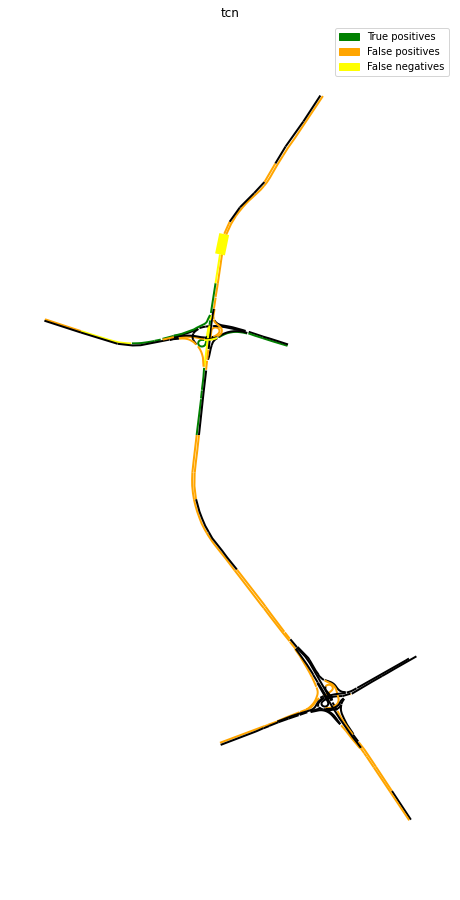

In [80]:
fig, ax = plt.subplots(figsize=(8,16))
plot_classification_errors(y_hat=results_dict[focus_model][41],
y_true=y_true,
seq_num=6,
incident_info=test_dataset.incident_info,
ind_to_edge=ind_to_edge,
net=net,
ax=ax)
ax.set_axis_off()
ax.set_title(focus_model)

Text(0.5, 1.0, 'tcn')

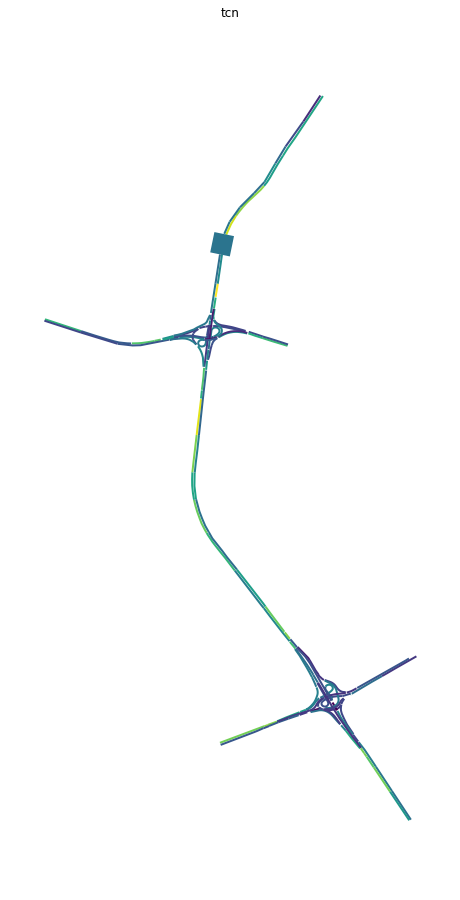

In [81]:
fig, ax = plt.subplots(figsize=(8,16))
plot_net_w_logits(y_hat=results_dict[focus_model][41],
                  seq_num=6,
                  incident_info=test_dataset.incident_info,
                  ind_to_edge=ind_to_edge,
                  net=net,
                  ax=ax)
ax.set_axis_off()
ax.set_title(focus_model)

Text(0.5, 1.0, 'False neg')

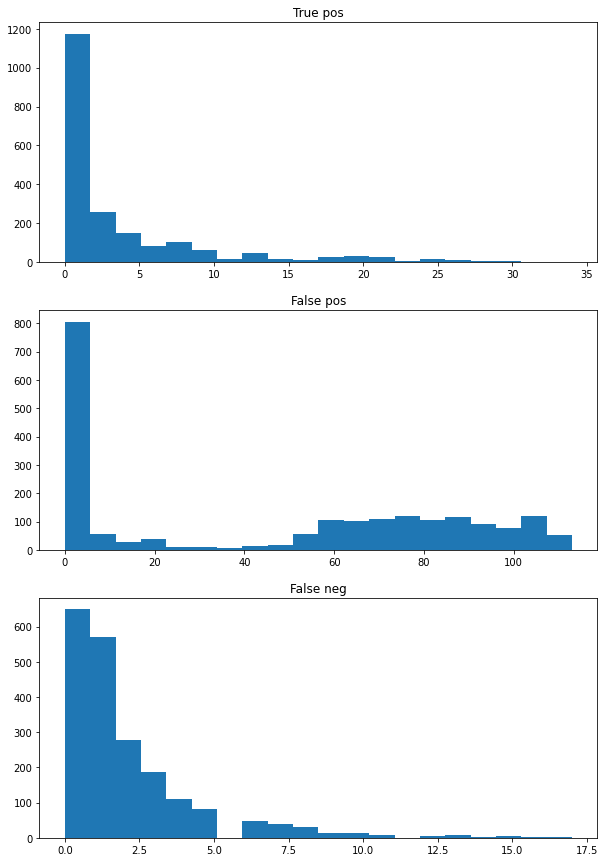

In [82]:
pred_classes = results_dict[focus_model][41][...,0] > 0
true_classes = y_true[...,0]
true_pos = pred_classes * true_classes
false_pos = pred_classes.int() - true_pos.int()
false_neg = true_classes.int() - true_pos.int()

fig, ax = plt.subplots(3, 1, figsize = (10,15))

ax[0].hist(true_pos.sum(1), bins=20)
ax[0].set_title('True pos')

ax[1].hist(false_pos.sum(1), bins=20)
ax[1].set_title('False pos')

ax[2].hist(false_neg.sum(1), bins=20)
ax[2].set_title('False neg')



# DCRNN

In [83]:
focus_model = 'dcrnn'

In [84]:
full_test_df[focus_model]

end                            start                           \
           mae         mape     Mmape       mae           mape     Mmape   
mean  4.168804  1609392.750  0.916363  1.299280  480661.312500  0.901648   
std   0.220662   205406.875  0.009632  0.071599   66333.992188  0.009476   

         speed                              class                      \
           mae           mape     Mmape       acc        f1     prcsn   
mean  1.253791  411119.562500  0.933427  0.844931  0.151825  0.105599   
std   0.073244   67557.296875  0.008873  0.022289  0.009080  0.003494   

                
          rcll  
mean  0.415553  
std   0.065817

In [85]:
upstream_test_df[focus_model]

end                             start                          \
            mae          mape     Mmape       mae          mape     Mmape   
mean  17.533247  2.115488e+06  0.916363  5.593444  631599.37500  0.901648   
std    0.106358  1.854723e+05  0.009632  0.031616   54133.59375  0.009476   

         speed                              class                      \
           mae           mape     Mmape       acc        f1     prcsn   
mean  5.692010  513850.562500  0.933427  0.674625  0.437711  0.363537   
std   0.049629   76548.117188  0.008873  0.012127  0.012369  0.007117   

                
          rcll  
mean  0.415553  
std   0.065817

In [86]:
not_upstream_test_df[focus_model]

end                         start                      speed  \
           mae          mape Mmape       mae       mape Mmape       mae   
mean  1.777018  1.518818e+06   NaN  0.530769  453648.50   NaN  0.459499   
std   0.244562  2.090279e+05   NaN  0.080384   68704.25   NaN  0.077520   

                              class                  
               mape Mmape       acc   f1 prcsn rcll  
mean  392734.187500   NaN  0.875410  0.0   0.0  0.0  
std    66256.148438   NaN  0.024202  0.0   0.0  0.0

In [87]:
multilane_test_df[focus_model] 

end                             start                           \
           mae          mape     Mmape       mae           mape     Mmape   
mean  4.912317  1.532008e+06  0.915669  1.529378  457474.218750  0.899555   
std   0.202601  1.951455e+05  0.009240  0.066124   63290.652344  0.008989   

         speed                              class                      \
           mae           mape     Mmape       acc        f1     prcsn   
mean  1.516421  392931.593750  0.932899  0.844733  0.199522  0.145595   
std   0.067801   64566.980469  0.008711  0.020240  0.011059  0.004644   

                
          rcll  
mean  0.430619  
std   0.069247

In [88]:
not_multilane_test_df[focus_model]

end                           start                           \
           mae        mape     Mmape       mae           mape     Mmape   
mean  3.207878  1709406.00  0.918428  1.001898  510628.593750  0.907876   
std   0.245524   219323.75  0.010821  0.079002   70432.132812  0.010944   

         speed                              class                      \
           mae           mape     Mmape       acc        f1     prcsn   
mean  0.914365  434625.937500  0.934999  0.845187  0.084223  0.054202   
std   0.080477   71498.171875  0.009374  0.024951  0.005102  0.002372   

                
          rcll  
mean  0.370717  
std   0.056342

In [89]:
highway_test_df[focus_model] 

end                             start                          \
           mae          mape     Mmape       mae          mape     Mmape   
mean  4.416198  1.598509e+06  0.915977  1.401861  476845.71875  0.903560   
std   0.212462  2.013501e+05  0.010410  0.068868   64942.40625  0.010139   

         speed                              class                      \
           mae           mape     Mmape       acc        f1     prcsn   
mean  1.371479  409347.375000  0.933697  0.843043  0.167778  0.117345   
std   0.071167   66638.796875  0.009144  0.021659  0.008603  0.003787   

                
          rcll  
mean  0.419444  
std   0.071795

In [90]:
not_highway_test_df[focus_model]

end                             start                           \
           mae          mape     Mmape       mae           mape     Mmape   
mean  3.759676  1.627392e+06  0.917239  1.129636  486971.375000  0.897312   
std   0.234752  2.122754e+05  0.008101  0.076317   68719.726562  0.008541   

         speed                              class                      \
           mae           mape     Mmape       acc        f1     prcsn   
mean  1.059164  414050.406250  0.932816  0.848053  0.123751  0.085641   
std   0.076706   69082.257812  0.008321  0.023334  0.009625  0.004616   

                
          rcll  
mean  0.406726  
std   0.053170

In [91]:
spreading_test_df[focus_model]

end                             start                           \
           mae          mape     Mmape       mae           mape     Mmape   
mean  5.831846  2.043976e+06  0.913919  1.820404  611300.125000  0.898497   
std   0.266708  2.531966e+05  0.009711  0.087150   82227.960938  0.009545   

         speed                             class                                
           mae          mape     Mmape       acc        f1     prcsn      rcll  
mean  1.745012  519847.68750  0.931142  0.799450  0.176795  0.124399  0.430774  
std   0.087853   82524.84375  0.009053  0.026984  0.009481  0.003904  0.067407

In [92]:
not_spreading_test_df[focus_model]

end                              start                           \
           mae           mape     Mmape       mae           mape     Mmape   
mean  1.094136  805926.312500  0.970638  0.335815  239133.531250  0.971630   
std   0.135716  117055.054688  0.007923  0.042864   36949.523438  0.008017   

         speed                              class                      \
           mae           mape     Mmape       acc        f1     prcsn   
mean  0.345612  210100.765625  0.984168  0.929017  0.010063  0.005185   
std   0.046292   39891.433594  0.004920  0.013643  0.000838  0.001062   

                
          rcll  
mean  0.077551  
std   0.030725

In [93]:
affected_test_df[focus_model]

end                          start                          speed  \
            mae      mape     Mmape        mae      mape     Mmape        mae   
mean  60.695992  0.916363  0.916363  19.567312  0.901648  0.901648  20.519917   
std    0.579751  0.009632  0.009632   0.167901  0.009476  0.009476   0.166709   

                             class                            
          mape     Mmape       acc        f1 prcsn      rcll  
mean  0.933427  0.933427  0.415553  0.737952   1.0  0.415553  
std   0.008873  0.008873  0.065817  0.063811   0.0  0.065817

In [94]:
not_affected_test_df[focus_model]

end                         start                          speed  \
           mae          mape Mmape       mae           mape Mmape       mae   
mean  1.956678  1.672374e+06   NaN  0.584382  499471.375000   NaN  0.499834   
std   0.249731  2.134454e+05   NaN  0.080648   68929.890625   NaN  0.082135   

                              class                  
               mape Mmape       acc   f1 prcsn rcll  
mean  427208.218750   NaN  0.861734  0.0   0.0  0.0  
std    70201.054688   NaN  0.025702  0.0   0.0  0.0

In [95]:
print(f'\tf1\tacc\tprcsn\trcll\tst mae\tend mae\tsp mae')
for hop in n_hop_dfs.keys():
    temp_df = n_hop_dfs[hop][focus_model]
    f1 = temp_df['class']['f1']
    acc = temp_df['class']['acc']
    prcsn = temp_df['class']['prcsn']
    rcll = temp_df['class']['rcll']
    start_mae = temp_df['start']['mae'] 
    end_mae = temp_df['end']['mae'] 
    speed_mae = temp_df['speed']['mae'] 
    print(f'{hop}:\t',
          f'{f1["mean"]:.02f}\t',
          f'{acc["mean"]:.02f}\t',
          f'{prcsn["mean"]:.02f}\t',
          f'{rcll["mean"]:.02f}\t',
          f'{start_mae["mean"]:.02f}\t',
          f'{end_mae["mean"]:.02f}\t',
          f'{speed_mae["mean"]:.02f}')


	f1	acc	prcsn	rcll	st mae	end mae	sp mae
0:	 0.41	 0.30	 0.86	 0.16	 8.56	 35.61	 17.40
1:	 0.53	 0.48	 0.89	 0.22	 7.28	 31.56	 13.31
2:	 0.57	 0.59	 0.78	 0.27	 7.08	 27.85	 10.80
3:	 0.60	 0.65	 0.70	 0.34	 7.10	 25.57	 9.15
4:	 0.61	 0.67	 0.63	 0.39	 7.06	 25.01	 8.24
5:	 0.60	 0.70	 0.58	 0.46	 6.66	 23.58	 7.32
6:	 0.61	 0.72	 0.55	 0.52	 6.73	 22.70	 6.89
7:	 0.60	 0.73	 0.53	 0.57	 6.97	 22.02	 6.57
8:	 0.57	 0.73	 0.49	 0.60	 6.96	 20.38	 6.06
9:	 0.54	 0.73	 0.46	 0.63	 7.42	 20.16	 5.74
10:	 0.52	 0.74	 0.43	 0.66	 7.51	 18.74	 5.14


In [96]:
print(f'\tf1\tacc\tprcsn\trcll\tst mae\tend mae\tsp mae')
for hop in n_hop_dfs.keys():
    temp_df = affected_n_hop_dfs[hop][focus_model]
    f1 = temp_df['class']['f1']
    acc = temp_df['class']['acc']
    prcsn = temp_df['class']['prcsn']
    rcll = temp_df['class']['rcll']
    start_mae = temp_df['start']['mae'] 
    end_mae = temp_df['end']['mae'] 
    speed_mae = temp_df['speed']['mae'] 
    print(f'{hop}:\t',
          f'{f1["mean"]:.02f}\t',
          f'{acc["mean"]:.02f}\t',
          f'{prcsn["mean"]:.02f}\t',
          f'{rcll["mean"]:.02f}\t',
          f'{start_mae["mean"]:.02f}\t',
          f'{end_mae["mean"]:.02f}\t',
          f'{speed_mae["mean"]:.02f}')

	f1	acc	prcsn	rcll	st mae	end mae	sp mae
0:	 0.42	 0.16	 1.00	 0.16	 10.57	 44.04	 21.59
1:	 0.55	 0.22	 1.00	 0.22	 11.11	 48.27	 20.41
2:	 0.63	 0.27	 1.00	 0.27	 13.47	 53.20	 20.77
3:	 0.70	 0.34	 1.00	 0.34	 15.66	 56.58	 20.47
4:	 0.75	 0.39	 1.00	 0.39	 17.25	 61.27	 20.45
5:	 0.80	 0.46	 1.00	 0.46	 18.30	 65.11	 20.50
6:	 0.85	 0.52	 1.00	 0.52	 19.97	 67.44	 20.82
7:	 0.86	 0.57	 1.00	 0.57	 22.03	 69.12	 20.95
8:	 0.88	 0.60	 1.00	 0.60	 24.43	 70.38	 21.34
9:	 0.89	 0.63	 1.00	 0.63	 27.53	 72.77	 21.05
10:	 0.91	 0.66	 1.00	 0.66	 30.91	 73.93	 20.59


Text(0.5, 1.0, 'dcrnn')

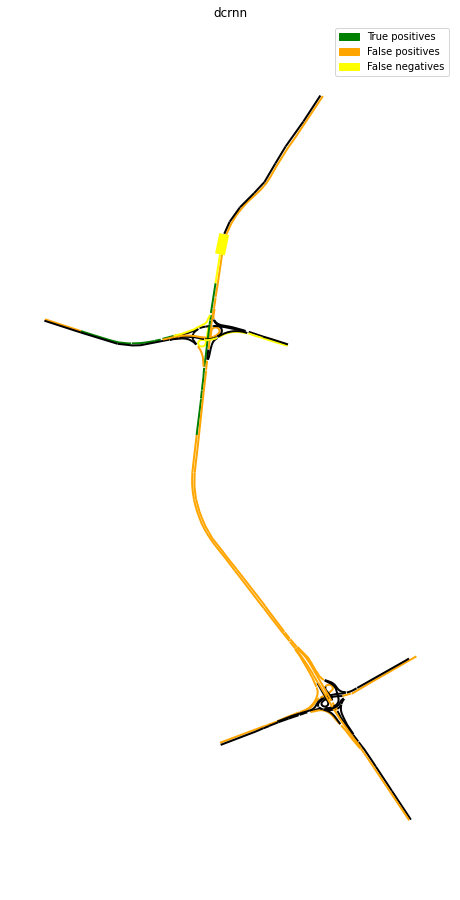

In [97]:
fig, ax = plt.subplots(figsize=(8,16))
plot_classification_errors(y_hat=results_dict[focus_model][41],
y_true=y_true,
seq_num=6,
incident_info=test_dataset.incident_info,
ind_to_edge=ind_to_edge,
net=net,
ax=ax)
ax.set_axis_off()
ax.set_title(focus_model)

Text(0.5, 1.0, 'dcrnn')

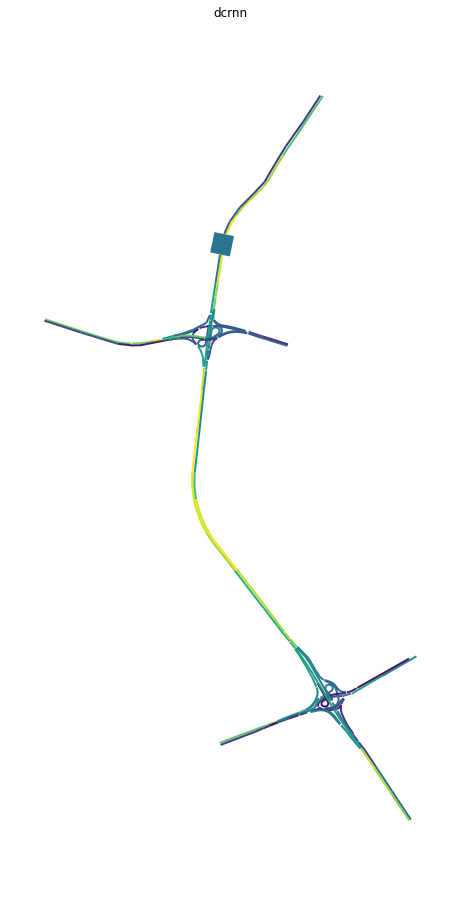

In [98]:
fig, ax = plt.subplots(figsize=(8,16))
plot_net_w_logits(y_hat=results_dict[focus_model][41],
                  seq_num=6,
                  incident_info=test_dataset.incident_info,
                  ind_to_edge=ind_to_edge,
                  net=net,
                  ax=ax)
ax.set_axis_off()
ax.set_title(focus_model)

Text(0.5, 1.0, 'False neg')

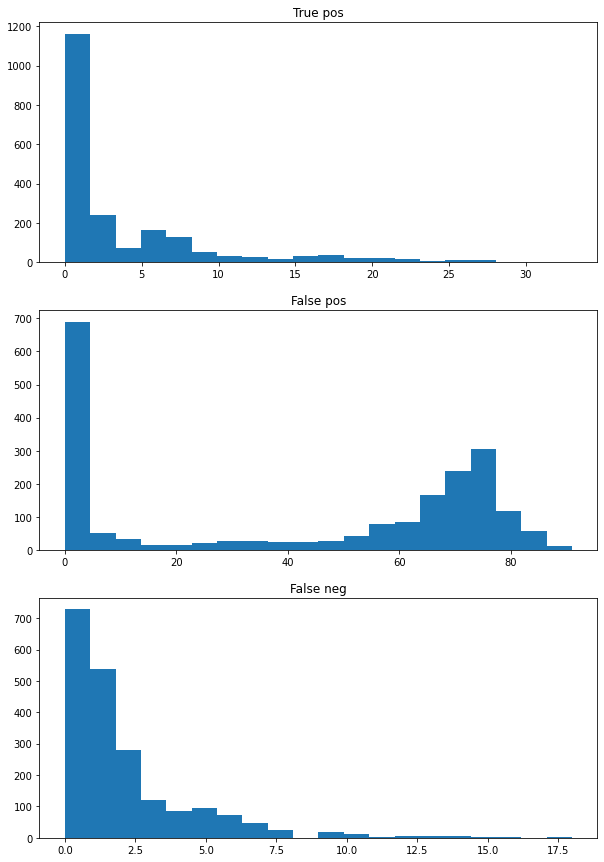

In [99]:
pred_classes = results_dict[focus_model][41][...,0] > 0
true_classes = y_true[...,0]
true_pos = pred_classes * true_classes
false_pos = pred_classes.int() - true_pos.int()
false_neg = true_classes.int() - true_pos.int()

fig, ax = plt.subplots(3, 1, figsize = (10,15))

ax[0].hist(true_pos.sum(1), bins=20)
ax[0].set_title('True pos')

ax[1].hist(false_pos.sum(1), bins=20)
ax[1].set_title('False pos')

ax[2].hist(false_neg.sum(1), bins=20)
ax[2].set_title('False neg')

